## Topics of hateful articles

Basado fuertemente en [esta notebook](https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Evaluate%20Topic%20Models.ipynb)

En esta notebook veremos los tópicos de los artículos que generan cierto odio

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-labelling", port=27018)
db = client["hatespeech-labelling"]

In [2]:
db.article.count()

/home/jmperez/.local/share/virtualenvs/hatespeech-labelling-i4Bxdr6F/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


55110

In [3]:
db.article.count_documents({"comments.19": {"$exists": True}})

6519

In [4]:

initial_query = {
    "comments.19": {"$exists": True}
}
articles = db.article.find(initial_query)
articles = list(articles)

print(len(articles))


6519


In [5]:
from tqdm.auto import tqdm

for article in tqdm(articles):
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hateful_comments"] = len(hateful_comments) / len(article["comments"])
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


<AxesSubplot:>

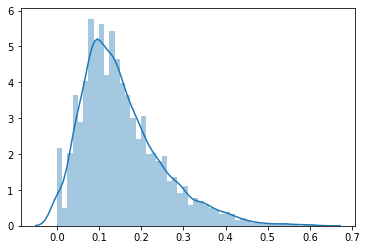

In [33]:
import seaborn as sns


sns.distplot([[art["avg_hateful_comments"] for art in articles]])

In [6]:
hateful_articles = [art for art in articles if art["avg_hateful_comments"] > 0.13]
len(hateful_articles)

3399

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
" - ".join(stop_words)

'de - la - que - el - en - y - a - los - del - se - las - por - un - para - con - no - una - su - al - lo - como - más - pero - sus - le - ya - o - este - sí - porque - esta - entre - cuando - muy - sin - sobre - también - me - hasta - hay - donde - quien - desde - todo - nos - durante - todos - uno - les - ni - contra - otros - ese - eso - ante - ellos - e - esto - mí - antes - algunos - qué - unos - yo - otro - otras - otra - él - tanto - esa - estos - mucho - quienes - nada - muchos - cual - poco - ella - estar - estas - algunas - algo - nosotros - mi - mis - tú - te - ti - tu - tus - ellas - nosotras - vosostros - vosostras - os - mío - mía - míos - mías - tuyo - tuya - tuyos - tuyas - suyo - suya - suyos - suyas - nuestro - nuestra - nuestros - nuestras - vuestro - vuestra - vuestros - vuestras - esos - esas - estoy - estás - está - estamos - estáis - están - esté - estés - estemos - estéis - estén - estaré - estarás - estará - estaremos - estaréis - estarán - estaría - estarías -

## Tokenizar

In [8]:
import spacy
from tqdm.auto import tqdm

nlp = spacy.load("es", disable=["parser", "ner"])

lemmatized_data = []

for art in tqdm(hateful_articles):
    lemmatized_data.append([t.lemma_.lower() for t in nlp(art["body"])])


In [54]:
import string

def is_punct_or_other(tok):
    return (tok in string.punctuation) or ("\n" in tok) or (len(tok) <= 3 and not tok.isalpha())


def filter_words(text):
    non_stop = [tok.strip() for tok in text if tok not in stop_words]
    non_punct = [tok for tok in non_stop if not is_punct_or_other(tok)]
    return non_punct

filtered_data = []

for text in tqdm(lemmatized_data):
    filtered_data.append(filter_words(text))

Sanity check

In [55]:


filter_words([t.string for t in nlp("Hola , esto. es una prueba e33 ?")])

['Hola', 'es', 'una', 'prueba']

In [51]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(filtered_data)

# Create Corpus
texts = filtered_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 4), (23, 4), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 5), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 4), (47, 1), (48, 12), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 4), (76, 1), (77, 1), (78, 1), (79, 1), (80, 8), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 3), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [52]:
import gensim
import pickle

num_topics = range(2, 40, 2)
# Build LDA model

try:
    with open("topic_models.pkl", "rb") as f:
        lda_models, coherence_models = pickle.load(f)        
except FileNotFoundError:
    lda_models = {}
    coherence_models = {}

Se me borró el gráfico pero el que mejor daba es 14 

In [53]:

for num in tqdm(num_topics):
    if num in lda_models:
        continue
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num, 
        random_state=100,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_models[num] = model
    coherence_models[num] = gensim.models.CoherenceModel(model, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')


Salvamos esto

In [56]:
import pickle

with open("topic_models.pkl", "wb") as f:
    pickle.dump((lda_models, coherence_models), f)

In [57]:
Y = [k.get_coherence() for k in coherence_models.values()]

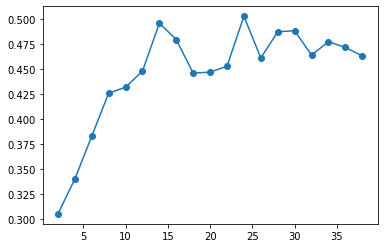

In [58]:
import matplotlib.pyplot as plt

plt.plot([k for k in coherence_models], Y, marker="o")

Agarro 14 que tiene casi la misma coherencia

In [59]:
lda_model = lda_models[14]

In [60]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.033*"año" + 0.029*"millón" + 0.016*"mercar" + 0.014*"carne" + '
  '0.013*"desarrollar" + 0.012*"usd" + 0.011*"tasar" + 0.010*"consumir" + '
  '0.010*"vacuno" + 0.009*"dólar"'),
 (1,
  '0.067*"ser" + 0.025*"tener" + 0.020*"haber" + 0.020*"hacer" + 0.017*"parir" '
  '+ 0.016*"decir" + 0.014*"comer" + 0.013*"poder" + 0.012*"ir" + 0.009*"si"'),
 (2,
  '0.026*"parir" + 0.019*"país" + 0.019*"ser" + 0.018*"haber" + '
  '0.010*"argentino" + 0.009*"argentina" + 0.008*"poder" + 0.008*"personar" + '
  '0.008*"comer" + 0.007*"según"'),
 (3,
  '0.017*"juez" + 0.017*"justicia" + 0.016*"causar" + 0.015*"ser" + '
  '0.012*"año" + 0.010*"denunciar" + 0.010*"fiscal" + 0.010*"parir" + '
  '0.010*"preso" + 0.009*"judicial"'),
 (4,
  '0.049*"arrepentir" + 0.026*"agredir" + 0.023*"gómez" + 0.020*"lesionar" + '
  '0.015*"david" + 0.013*"ufi" + 0.013*"canosa" + 0.011*"intimar" + '
  '0.010*"león" + 0.008*"incurrir"'),
 (5,
  '0.022*"policía" + 0.018*"seguridad" + 0.018*"ciudad" + 0.014*"vecino" + '


In [61]:
# Print the Keyword in the 10 topics

doc_lda = lda_model[corpus]

In [62]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.061306  0.254368       1        1  41.205178
2     -0.075011  0.276090       2        1  15.046519
8     -0.102695  0.112851       3        1   8.051373
13    -0.287816  0.290976       4        1   8.039938
6      0.090118  0.382089       5        1   6.660156
3      0.251126  0.211018       6        1   4.978886
9     -0.337667  0.042491       7        1   4.226326
5     -0.186018 -0.129148       8        1   3.260068
10     0.207727 -0.095477       9        1   2.386520
7     -0.060853 -0.425686      10        1   2.117636
12    -0.333169 -0.303308      11        1   1.989514
0      0.396532 -0.003162      12        1   1.961139
4      0.203454 -0.319957      13        1   0.075579
11     0.172966 -0.293146      14        1   0.001167, topic_info=             Term          Freq         Total Category  logprob  loglift
342        gustar   3112.000000   3112.000000  Default  30.0000  30.0000
39            año   5623.000000   5623.000000  Default  29.0000  29.0000
177         parir  21138.000000  21138.000000  Default  28.0000  28.0000
76          decir   9192.000000   9192.000000  Default  27.0000  27.0000
392    presidente   4364.000000   4364.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
13931    grabarse      0.000351      1.063028  Topic14 -10.6389   3.3424
13930     doblaje      0.000351      1.062882  Topic14 -10.6389   3.3426
13929         cid      0.000351      1.063907  Topic14 -10.6389   3.3416
13928      cherri      0.000351      1.062933  Topic14 -10.6389   3.3425
13927     celeste      0.000351      1.065729  Topic14 -10.6389   3.3399

[892 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3370     12  0.932620  -¿cree
4         1  0.188884    2019
4         2  0.082286    2019
4         4  0.140260    2019
4         5  0.130910    2019
...     ...       ...     ...
822       7  0.257192    área
822      12  0.009988    área
823       2  0.150999  índice
823       3  0.137272  índice
823      12  0.700086  índice

[1741 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 9, 14, 7, 4, 10, 6, 11, 8, 13, 1, 5, 12])

1. Tema "general" (verbos, y otras cosas)
2. Tema "internacional" (China, Trump, avión, extranjero, y otros)
3. AMBA/CABA: Kicillof, Larreta, Berni: política CABA, AMBA y demás
4. JxC vs FDT: Macri, Cristina, expropiación, Senado, etc
5. Conflictos sindicales y económicos: sindicatos, agropecuario, ife, empresa, pagar, gasto, trabajador
6. Criminales, cárceles y cubanos (!)
7. Conflictos rurales? Delincuentes
8. Pu Lof, Chubut
9. Carla Vizzotti, hisopados, síntomas, mosquito
10. Artefacto de "me gusta, facebook, compartir, blabla"
11. Notas acerca de famosas: Jimena Barón, Guillermina Valdés, "actriz"
12. Deuda externa y otros temas
13. Ruido
14. Ruido

In [ ]:
temas = [
    "general",
    "internacional",
    "amba/caba",
    "cambiemos vs fdt",
    "sindicales/económicos",
    "cárceles y cubanos",
    "rurales",
    "policiales y manifestaciones",
    "salud",
    "brasil y ruido",
    "mujeres",
    "deuda",
    "ruido 13",
    "ruido 14",
]

In [63]:
len(corpus), len(hateful_articles)

(3399, 3399)

In [64]:
num = 3


hateful_articles[num]["title"], lda_model.get_document_topics(corpus[num])

('Brasil se encamina a la tormenta perfecta: coronavirus, influenza, dengue y sarampión',
 [(0, 0.13679075),
  (1, 0.24007076),
  (2, 0.2784064),
  (6, 0.037712395),
  (7, 0.017883848),
  (8, 0.08598338),
  (10, 0.17162658),
  (13, 0.025127573)])